In [1]:
from pathlib import Path
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
p = Path("./Dataset/")

dirs = p.glob("*")

image_data = []
labels = []

label_dict = {"Pikachu":0,"Bulbasaur":1,"Meowth":2}
label2pokemon = {0:"Pikachu",1:"Bulbasaur",2:"Meowth"}

for folder_dir in dirs:
    label = str(folder_dir).split("\\")[-1] 
    cnt = 0
    print("Iterating over dir: ",folder_dir)
    
    for img_path in folder_dir.glob("*.jpg"):
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,(40,40))
        img_array = img.reshape((-1,))
        image_data.append(img_array)
        labels.append(label_dict[label])
        cnt += 1
        
    print(f"Total images of pokemon {label} are: ",cnt,end="\n\n")

Iterating over dir:  Dataset\Bulbasaur
Total images of pokemon Bulbasaur are:  173

Iterating over dir:  Dataset\Meowth
Total images of pokemon Meowth are:  70

Iterating over dir:  Dataset\Pikachu
Total images of pokemon Pikachu are:  199



In [3]:
print(len(image_data))
print(len(labels))

442
442


In [4]:
import random
random.seed(10)

In [5]:
X = np.array(image_data)
Y = np.array(labels)
 
from sklearn.utils import shuffle
X,Y = shuffle(X,Y,random_state=2)

X = X/255.0

In [6]:
def drawImg(img,label):
    plt.title(label2pokemon[label])
    plt.imshow(img)
    plt.style.use("seaborn")
    plt.axis("off")
    plt.show()

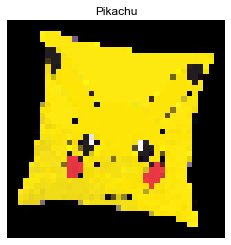

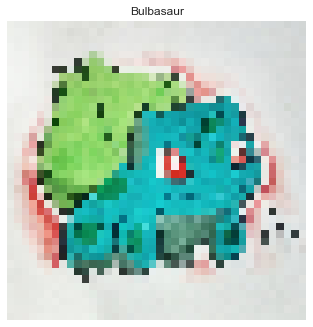

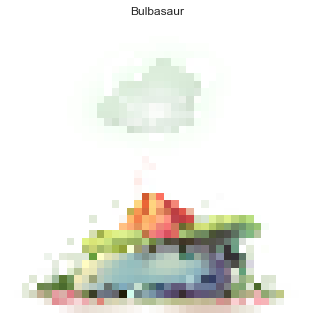

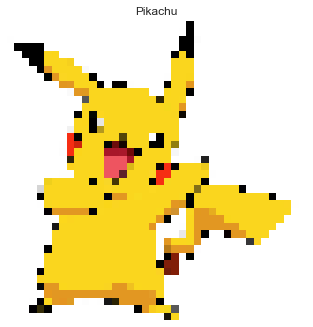

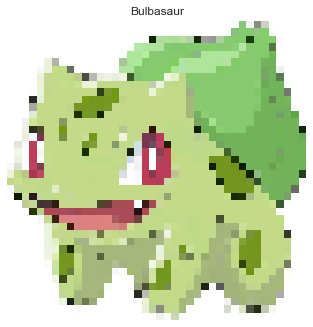

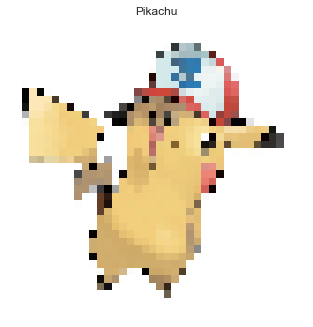

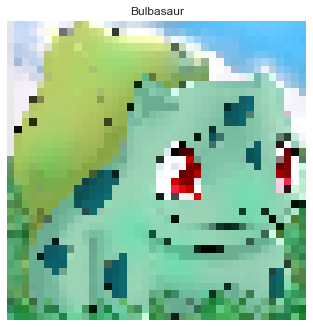

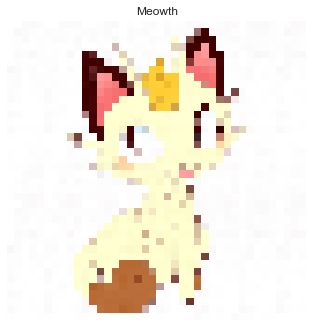

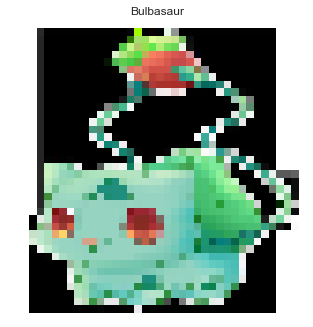

In [7]:
for i in range(1,10):
    drawImg(X[i].reshape(40,40,3),Y[i])

In [8]:
split = int(X.shape[0]*0.8)

X_ = np.array(X)
Y_ = np.array(Y)

X = X_[:split,:]
Y = Y_[:split]

XTest = X_[split:,:]
YTest = Y_[split:]

print("X shape:",X.shape)
print("Y shape:",Y.shape)
print("XTest shape:",XTest.shape)
print("YTest shape:",YTest.shape)

X shape: (353, 4800)
Y shape: (353,)
XTest shape: (89, 4800)
YTest shape: (89,)


In [9]:
class NeuralNetwork:
    
    def __init__(self,input_size,layers,output_size):
        np.random.seed(0)
        
        model = {}
        
        model['W1'] = np.random.randn(input_size,layers[0])
        model['b1'] = np.zeros((1,layers[0]))
        
        model['W2'] = np.random.randn(layers[0],layers[1])
        model['b2'] = np.zeros((1,layers[1]))
        
        model['W3'] = np.random.randn(layers[1],output_size)
        model['b3'] = np.zeros((1,output_size))
        
        self.model = model
        self.activation_outputs = None
    
    def forward(self,x):
        
        W1,W2,W3 = self.model['W1'],self.model['W2'],self.model['W3']
        b1, b2, b3 = self.model['b1'],self.model['b2'],self.model['b3']
        
        z1 = np.dot(x,W1) + b1
        a1 = np.tanh(z1) 
        
        z2 = np.dot(a1,W2) + b2
        a2 = np.tanh(z2)
        
        z3 = np.dot(a2,W3) + b3
        y_ = softmax(z3)
        
        self.activation_outputs = (a1,a2,y_)
        return y_
        
    def backward(self,x,y,learning_rate=0.001):
        W1,W2,W3 = self.model['W1'],self.model['W2'],self.model['W3']
        b1, b2, b3 = self.model['b1'],self.model['b2'],self.model['b3']
        m = x.shape[0]
        
        a1,a2,y_ = self.activation_outputs
        
        delta3 = y_ - y
        dw3 = np.dot(a2.T,delta3)
        db3 = np.sum(delta3,axis=0)
        
        delta2 = (1-np.square(a2))*np.dot(delta3,W3.T)
        dw2 = np.dot(a1.T,delta2)
        db2 = np.sum(delta2,axis=0)
        
        delta1 = (1-np.square(a1))*np.dot(delta2,W2.T)
        dw1 = np.dot(X.T,delta1)
        db1 = np.sum(delta1,axis=0)
        
        self.model["W1"]  -= learning_rate*dw1
        self.model['b1']  -= learning_rate*db1
        
        self.model["W2"]  -= learning_rate*dw2
        self.model['b2']  -= learning_rate*db2
        
        self.model["W3"]  -= learning_rate*dw3
        self.model['b3']  -= learning_rate*db3
        
        
    def predict(self,x):
        y_out = self.forward(x)
        return np.argmax(y_out,axis=1)
    
    def summary(self):
        W1,W2,W3 = self.model['W1'],self.model['W2'],self.model['W3']
        a1,a2,y_ = self.activation_outputs
        
        print("W1 ",W1.shape)
        print("A1 ",a1.shape)

def softmax(a):
    e_pa = np.exp(a) #Vector
    ans = e_pa/np.sum(e_pa,axis=1,keepdims=True)
    return ans    

In [10]:
def loss(y_oht,p):
    l = -np.mean(y_oht*np.log(p))
    return l

def one_hot(y,depth):
    
    m = y.shape[0]
    y_oht = np.zeros((m,depth))
    y_oht[np.arange(m),y] = 1
    return y_oht

In [11]:
def train(X,Y,model,epochs,learning_rate,logs=True):
    training_loss = []
    
    classes = len(np.unique(Y))
    Y_OHT = one_hot(Y,classes)
    
    for ix in range(epochs):
        
        Y_ = model.forward(X)
        l = loss(Y_OHT,Y_)
        
        model.backward(X,Y_OHT,learning_rate)
        training_loss.append(l)
        if(logs and ix%50==0):
            print("Epoch %d Loss %.4f"%(ix,l))
            
    
    return training_loss

In [12]:
model = NeuralNetwork(input_size=4800,layers=[100,50],output_size=3) #4800 features(40X40X3)

In [13]:
print(X.shape)

(353, 4800)


In [14]:
X = X.reshape(X.shape[0],-1)
print(X.shape)

XTest = XTest.reshape(XTest.shape[0],-1)
print(XTest.shape)

(353, 4800)
(89, 4800)


In [15]:
l = train(X,Y,model,800,0.0002)

Epoch 0 Loss 3.2803
Epoch 50 Loss 0.2422
Epoch 100 Loss 0.1279
Epoch 150 Loss 0.0886
Epoch 200 Loss 0.0693
Epoch 250 Loss 0.0479
Epoch 300 Loss 0.0386
Epoch 350 Loss 0.0320
Epoch 400 Loss 0.0276
Epoch 450 Loss 0.0243
Epoch 500 Loss 0.0217
Epoch 550 Loss 0.0195
Epoch 600 Loss 0.0176
Epoch 650 Loss 0.0159
Epoch 700 Loss 0.0146
Epoch 750 Loss 0.0135


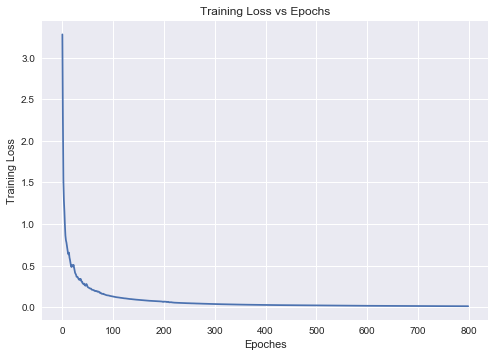

In [16]:
plt.title("Training Loss vs Epochs")
plt.plot(l)
plt.xlabel("Epoches")
plt.ylabel("Training Loss")
plt.show()

In [17]:
 def getAccuracy(X,Y,model):
    outputs = model.predict(X)
    acc = np.sum(outputs==Y)/Y.shape[0]
    return acc
    
print("Train Acc %.4f"%getAccuracy(X,Y,model))
print("Test Acc %.4f"%getAccuracy(XTest,YTest,model))

Train Acc 0.9943
Test Acc 0.6404


In [18]:
from sklearn.metrics import confusion_matrix

In [19]:
outputs = model.predict(X)
cnf_matrix = confusion_matrix(outputs,Y)
print(cnf_matrix)

[[161   1   0]
 [  0 131   1]
 [  0   0  59]]


In [20]:
output_test = model.predict(XTest)
c_matrix = confusion_matrix(output_test,YTest)
print(c_matrix)

[[27 10  4]
 [ 7 27  3]
 [ 4  4  3]]


In [21]:
from sklearn.metrics import classification_report

In [22]:
print(classification_report(outputs,Y))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       162
           1       0.99      0.99      0.99       132
           2       0.98      1.00      0.99        59

    accuracy                           0.99       353
   macro avg       0.99      1.00      0.99       353
weighted avg       0.99      0.99      0.99       353



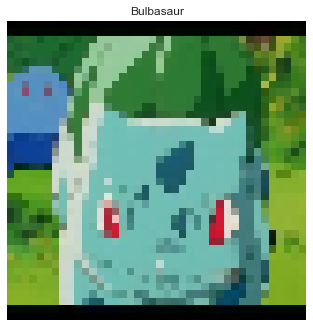

Prediction 58 Pikachu


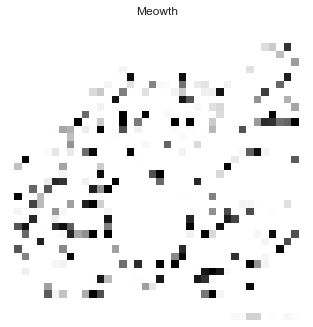

Prediction 351 Bulbasaur


In [23]:
for i in range(Y.shape[0]):
    if Y[i] != outputs[i]:
        drawImg(X[i].reshape(40,40,3),Y[i])
        print("Prediction %d %s"%(i,label2pokemon[outputs[i]]))